# Centrality in actor graph and popularity. Are they linked?

In [1]:
#| echo: false
#| output: false
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pydot
import itertools
import pickle

In [2]:
#| echo: false
#| output: false
def get_or_init_pickle(path, init):
    try:
        value = pickle.load(open(path, "rb"))
        return value
    except (OSError, IOError) as e:
        print(path + " not found, computing it from init()")
        value = init()
        try:
            pickle.dump(value, open(path, "wb"))
        except Exception as e:
            print("could not pickle: " + e)
        return value

We want to use wikipedia pageviews as a proxy for popularity, and try to find a correlation the centrality of actors in the actor graph. For this we used the [dataset of pageviews](https://github.com/epfl-ada/2022/blob/main/Homework/02%20-%20Regression%20Observational%20Studies%20Stats%20and%20Supervised%20Learning/data/all_entities.csv.gz) from Homework 2. Since Wikipedia was founded at the start of the century, pageviews might not be relevant for older actors. To eliminate this possible bias we only considered only actors having played in recent movies and formed the actor-graph only based on the recent movies.

In [3]:
#| echo: false
#| output: false
df_roles = pd.read_pickle("../data/generated/preprocessed/roles.pkl")
edges = []

recent_roles = df_roles.loc[df_roles.release_year >= 2005].dropna(subset=['fb_actor_id'])

for movie_fbid, df_actor_movie in recent_roles.groupby('fb_movie_id'):
	# NOTE : we need to sort the edges, because we only store i -> j, but want an undirected graph
	# NOTE : we need to use unique(), because some actors play multiple characters in the same movie
	# e.g. df_actors.query('fb_movie_id == "/m/011xrr"')
	edges += [ (*sorted((actor1_fbid, actor2_fbid)), movie_fbid )
		for actor1_fbid, actor2_fbid 
              in itertools.combinations(df_actor_movie.fb_actor_id.unique(), r=2) ]

df_edges = pd.DataFrame(edges, columns=['actor1_fbid', 'actor2_fbid', 'movie_fbid'])

# sanity check that we indeed have ordered edges
assert (df_edges['actor1_fbid'] < df_edges['actor2_fbid']).all()

In [4]:
#| echo: false
#| output: false
df_edges_grouped = (df_edges
	.groupby(['actor1_fbid', 'actor2_fbid'])
	[['movie_fbid']]
	.count()
	.reset_index()
	.sort_values('movie_fbid', ascending=False)  # movie_fbid count is the edge weight !!
)

df_edges_grouped.rename(columns={'movie_fbid': 'movie_count'}, inplace=True)

In [5]:
#| echo: false
#| output: false
df_actors = pd.read_pickle("../data/generated/preprocessed/actors.pkl")
df_actors = df_actors.loc[df_actors.actor_name.notna()]
actor_graph = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
actor_graph = actor_graph.subgraph(df_actors.fb_actor_id).copy()

In [6]:
#| echo: false
#| output: false
# a mapping from freebaseid to actor names
fbid2name = dict((row.fb_actor_id, row.actor_name) for _, row in df_actors.iterrows())
fbid2name_newline = dict((row.fb_actor_id, row.actor_name.replace(' ', '\n')) for _, row in df_actors.iterrows())  # for displaying graphs

actor_graph_names = nx.relabel_nodes(actor_graph, fbid2name)

In [7]:
#| echo: false
#| output: false
# create a list of connected components
actor_graph_comps = [actor_graph.subgraph(c).copy() for c in nx.connected_components(actor_graph)]
actor_subgraph = max(actor_graph_comps, key=lambda G: G.number_of_nodes())
actor_subgraph_names = nx.relabel_nodes(actor_subgraph, fbid2name_newline)

In [8]:
#| echo: false
#| output: false
actors = set(actor_subgraph.nodes())
nactors = len(actors)
nmovies = df_roles[df_roles.fb_actor_id.apply(lambda x: x in actors)].fb_movie_id.nunique()
nactors_with_pageviews = df_actors[df_actors.fb_actor_id.apply(lambda x: x in actors)].pageviews.count()

print("We therefore consider %d actors accross %d movies, %d of which (the actors) \
we have the pageview count."%(nactors, nmovies, nactors_with_pageviews))

We therefore consider 49481 actors accross 41039 movies, 4631 of which (the actors) we have the pageview count.


We therefore consider 49481 actors accross 41039 movies, 4631 of which (the actors) we have the pageview count.


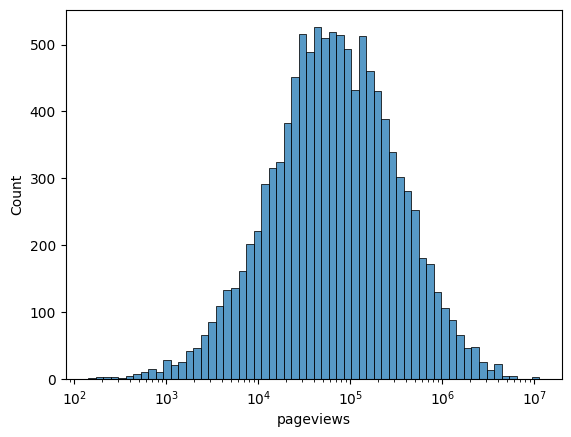

In [58]:
#| echo: false
sns.histplot(data=df_actors.pageviews, log_scale=True);

## Computing centrality

We focused on three metrics of centrality:
- Degree centrality: With how many other actors have the actors played
- Eigenvector centrality
- Betweenness: how much an actor bridges communities of actors

In [9]:
#| echo: false
#| output: false
degree_centrality = nx.degree_centrality(actor_subgraph)
eigenvector_centrality = nx.eigenvector_centrality(actor_subgraph)
betweenness_centrality = nx.betweenness_centrality(actor_subgraph, k=300)

In [10]:
#| echo: false
#| output: false
df_centrality = pd.DataFrame(degree_centrality.items(), columns=['fb_actor_id', 'degree_centrality'])
df_centrality = df_centrality.merge(pd.DataFrame(eigenvector_centrality.items(), columns=['fb_actor_id', 'eigenvector_centrality']), on='fb_actor_id', how='left')
df_centrality = df_centrality.merge(pd.DataFrame(betweenness_centrality.items(), columns=['fb_actor_id', 'betweenness_centrality']), on='fb_actor_id', how='left')
df_centrality['actor_name'] = df_centrality.fb_actor_id.map(lambda i: fbid2name[i])

### Who are the most central actors

For those interested, we list here the most central actors.

In [11]:
#| echo: false
df_centrality.sort_values('degree_centrality', ascending=False)[['degree_centrality', 'actor_name', 'fb_actor_id']].head(5)

,degree_centrality,actor_name,fb_actor_id
70,0.011601,Anupam Kher,/m/0292l3
744,0.010853,Jane Lynch,/m/07m77x
748,0.010287,Samuel L. Jackson,/m/0f5xn
710,0.009903,David Koechner,/m/059j1m
202,0.009863,Justin Long,/m/07cjqy


In [12]:
#| echo: false
df_centrality.sort_values('eigenvector_centrality', ascending=False)[['eigenvector_centrality', 'actor_name']].head(5)

,eigenvector_centrality,actor_name
1150,0.095907,David Strathairn
6434,0.095699,Nicole Kidman
4889,0.095603,Clive Owen
6102,0.094613,Parker Posey
4467,0.094151,Rodrigo Santoro


In [13]:
#| echo: false
df_centrality.sort_values('betweenness_centrality', ascending=False)[['betweenness_centrality', 'actor_name']].head(5)

,betweenness_centrality,actor_name
70,0.019429,Anupam Kher
5728,0.011046,Lee Byung-Hun
10,0.010051,Nassar
6198,0.009872,Peter Stormare
5257,0.009498,Vera Farmiga


## Comparing centrality to pageviews

In [14]:
#| echo: false
#| output: false
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Naïve visualisation

We first try to visualise the two values together.

In [15]:
#| echo: false
df_actors.index = df_actors.fb_actor_id

For degree centrality.
	We find an average increase of 57.248% in pageviews per 10x increase in centrality
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4939      0.075     72.967      0.000       5.346       5.642
centrality     0.1966      0.022      8.805      0.000       0.153       0.240

For eigenvector centrality.
	We find an average increase of 13.791% in pageviews per 10x increase in centrality
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0638      0.031    163.986      0.000       5.003       5.124
centrality     0.0561      0.007      7.767      0.000       0.042       0.070

For betweenness centrality.
	We find an average increase of 16.761% in pageviews per 10x increase in centrality
                 coef    std err   

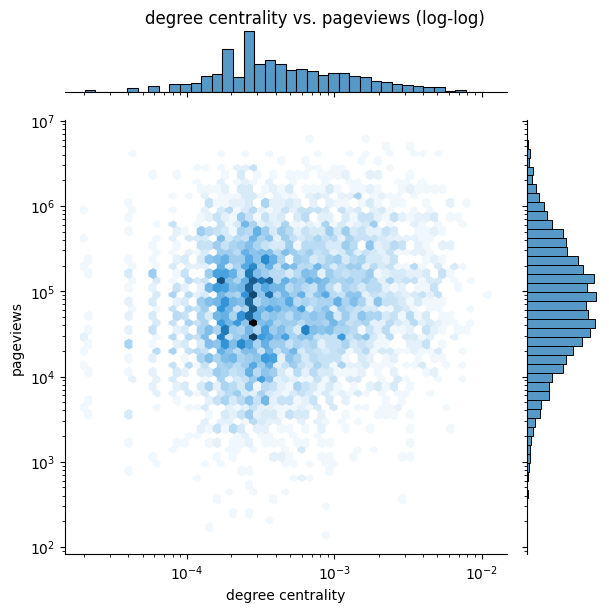

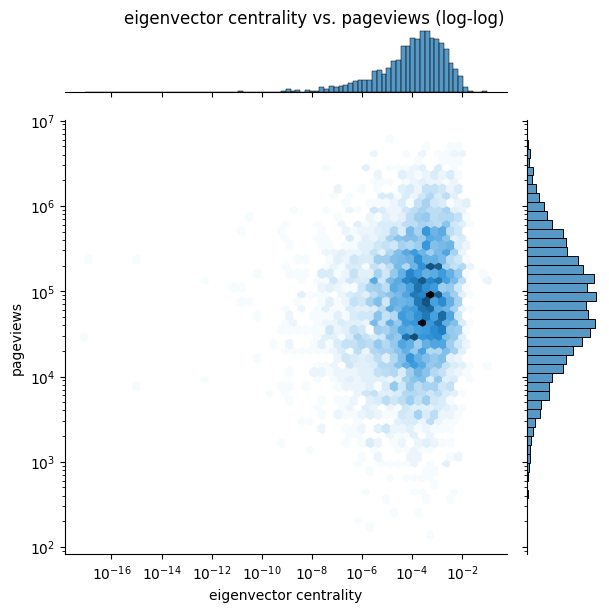

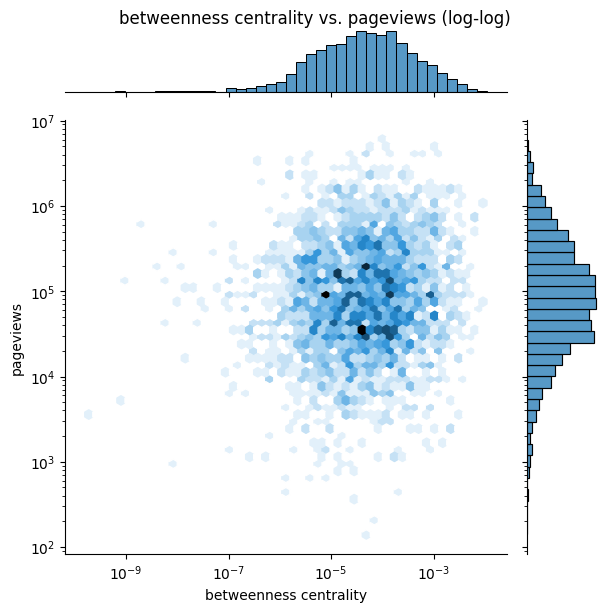

In [30]:
#| echo: false
#| output: false
r_squared = {}
for c, t in zip([degree_centrality, eigenvector_centrality, betweenness_centrality],
                ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    centrality = [c[node] for node in actor_subgraph.nodes() if 
                  not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    pageviews = [df_actors.pageviews[node] for node in actor_subgraph.nodes() if 
                 not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    g = sns.jointplot(x=centrality, y=pageviews, kind="hex", xscale="log", yscale="log")
    g.fig.suptitle(t.replace("_", " ") + " vs. pageviews (log-log)")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.set_axis_labels(t.replace("_", " "),"pageviews")
    
    model = smf.ols(formula="pageviews ~ centrality", 
                    data={
                        "pageviews": np.log10(np.array(pageviews)),
                        "centrality": np.log10(np.array(centrality))
                    })

    np.random.seed(83)
    res = model.fit()
    
    increase = math.pow(10,res.params["centrality"]) * 100 -100
    r_squared[t] = float(res.summary().tables[0].data[0][3].strip()) * 100

    print("For %s.\n\tWe find an average increase of %.3f%% in pageviews per 10x increase in centrality" % (t.replace("_", " "), increase))
    print(res.summary().tables[1])
    print()

The correlations we found were very modest with R^2 values of 0.016, 0.013, and 0.007 respectively

### The impact of movie count

In [17]:
#| echo: false
#| output: false
movie_counts = df_roles.groupby(by=["fb_actor_id"]).fb_movie_id.nunique()
df_actors["movie_count"] = movie_counts

For movie count.
	We find an average increase of 50.742% in pageviews per 10x increase in movie count
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.7326      0.015    324.735      0.000       4.704       4.761
movie_count     0.1782      0.018      9.787      0.000       0.143       0.214


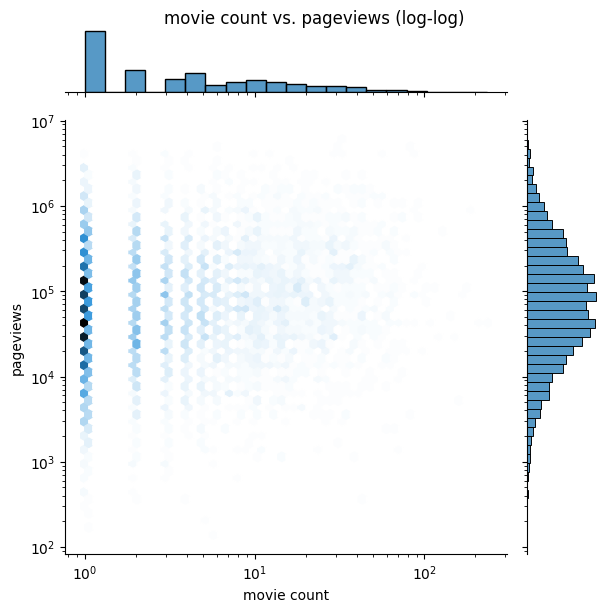

In [18]:
#| echo: false
t = "movie_count"
movie_counts = [df_actors.movie_count[node] for node in actor_subgraph.nodes() if 
              not pd.isna(df_actors.pageviews[node]) and df_actors.movie_count[node] > 0]
pageviews = [df_actors.pageviews[node] for node in actor_subgraph.nodes() if 
             not pd.isna(df_actors.pageviews[node]) and df_actors.movie_count[node] > 0]
g = sns.jointplot(x=movie_counts, y=pageviews, kind="hex", xscale="log", yscale="log")
g.fig.suptitle(t.replace("_", " ") + " vs. pageviews (log-log)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
g.set_axis_labels(t.replace("_", " "),"pageviews")

model = smf.ols(formula="pageviews ~ movie_count", 
                data={
                    "pageviews": np.log10(np.array(pageviews)),
                    "movie_count": np.log10(np.array(movie_counts))
                })

np.random.seed(83)
res = model.fit()

increase = math.pow(10,res.params["movie_count"]) * 100 -100

print("For %s.\n\tWe find an average increase of %.3f%% in pageviews per 10x increase in movie count" % (t.replace("_", " "), increase))
print(res.summary().tables[1])

For degree centrality.
	We find an average increase of 3.7x in centrality per 10x increase in movie count
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.6732      0.007   -529.463      0.000      -3.687      -3.660
movie_count     0.5656      0.009     65.250      0.000       0.549       0.583

For eigenvector centrality.
	We find an average increase of 19.8x in centrality per 10x increase in movie count
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.8026      0.026   -187.939      0.000      -4.853      -4.753
movie_count     1.2970      0.032     40.620      0.000       1.234       1.360

For betweenness centrality.
	We find an average increase of 10.7x in centrality per 10x increase in movie count
                  coef    st

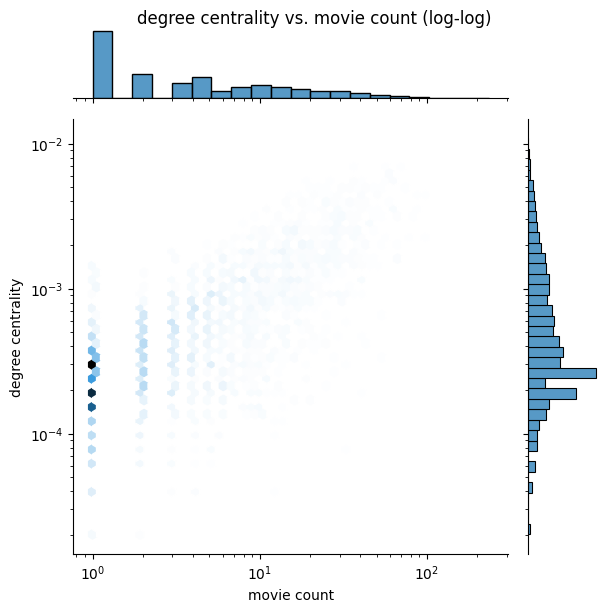

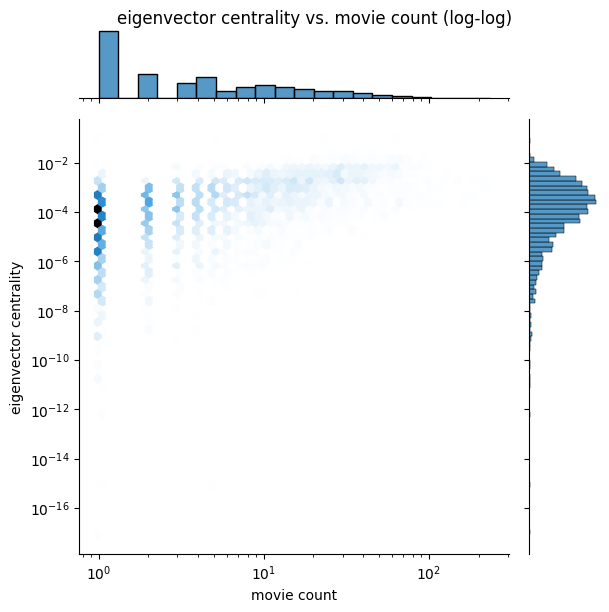

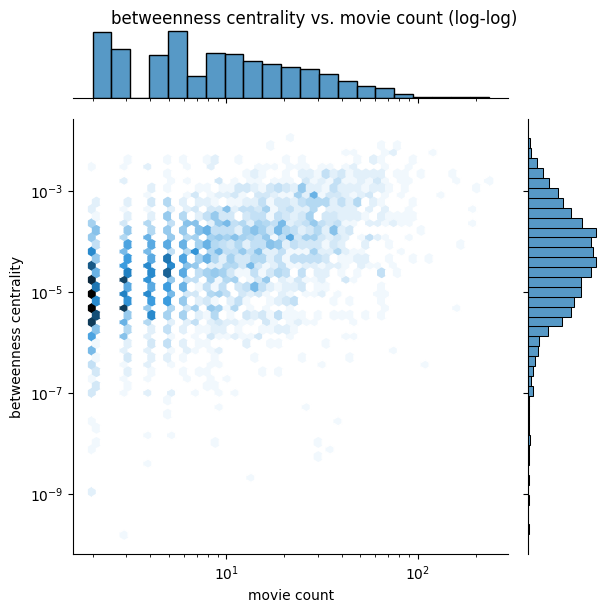

In [26]:
#| echo: false
r_squared = {}
for c, t in zip([degree_centrality, eigenvector_centrality, betweenness_centrality], ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    centrality = [c[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    movies = [df_actors.movie_count[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    g = sns.jointplot(x=movies, y=centrality, kind="hex", xscale="log", yscale="log")
    
    g.fig.suptitle(t.replace("_", " ") + " vs. movie count (log-log)")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.set_axis_labels("movie count",t.replace("_", " "))

    model = smf.ols(formula="centrality ~ movie_count", 
                    data={
                        "centrality": np.log10(np.array(centrality)),
                        "movie_count": np.log10(np.array(movies))
                    })

    np.random.seed(83)
    res = model.fit()

    increase = math.pow(10,res.params["movie_count"])
    r_squared[t] = float(res.summary().tables[0].data[0][3].strip())

    print("For %s.\n\tWe find an average increase of %.1fx in centrality per 10x increase in movie count" % (t.replace("_", " "), increase))
    print(res.summary().tables[1])
    print()

Here the values are better correlated, with R^2 values of 0.479, 0.263, and 0.212 respectively.
Movie count having a significant correlation with pageviews as well as with centrality, it acts as a confounder. We therefore aim to isolate the effects of centrality from those of movie count by using A/B testing

### The A/B tests

The A/B test is done by making pairs of actors with similar numbers of movies (Here similar means that their number of movies are less than 5% different) such that the first actor has a lower centrality than the second.

In [20]:
#| echo: false
#| output: false
df_central_actors = pd.merge(df_actors.reset_index(drop = True), df_centrality.drop("actor_name", axis=1), on="fb_actor_id")
df_central_actors = df_central_actors.sort_values(by="movie_count").reset_index(drop=True)

In [21]:
#| echo: false
#| output: false
def are_similar(a1, a2):
    a1_count = a1["movie_count"]
    a2_count = a2["movie_count"]
    return 0.05 > abs(a1_count - a2_count)/min(a1_count, a2_count)

def ab_test_set(centrality):
    tmp_df = []
    for i in range(len(df_central_actors)):
        
        maxj = min(i + 100, len(df_central_actors) - 1)
        minj = max(0, i - 100)
        
        a1 = dict(df_central_actors.loc[i, :])
        
        # First find upper bound of similar actors
        a2 = a1
        j = i
        while are_similar(a1, a2):
            if j + 1 > maxj:
                break
            j = j + 1
            a2 = dict(df_central_actors.loc[j, :])
            
        # Second iterate down on all similar actors
        while are_similar(a1, a2):
            if a1[centrality] < a2[centrality]:
                tmp = a1
                a1 = a2
                a2 = tmp
                        
            if not a1[centrality] == a2[centrality]:
                tmp_df.append({
                    "fb_actor_id1": a1["fb_actor_id"],
                    "fb_actor_id2": a2["fb_actor_id"],
                    centrality + "1": a1[centrality],
                    centrality + "2": a2[centrality],
                    "pageviews1": a1["pageviews"],
                    "pageviews2": a2["pageviews"],
                    "diff_pageviews": a2["pageviews"] - a1["pageviews"],
                    "movie_count": a1["movie_count"] // 2 + a2["movie_count"] // 2
                })
                
            if j <= minj:
                break
            j = j - 1
            a2 = dict(df_central_actors.loc[j, :])
            
    df_final = pd.DataFrame(tmp_df)
    return df_final

In [60]:
#| echo: false
ab_test_degree = get_or_init_pickle("../data/generated/graph/ab_test_degree.pkl", lambda: ab_test_set("degree_centrality"))
ab_test_eigenvector = get_or_init_pickle("../data/generated/graph/ab_test_eigenvector.pkl", lambda: ab_test_set("eigenvector_centrality"))
ab_test_betweenness = get_or_init_pickle("../data/generated/graph/ab_test_betweenness.pkl", lambda: ab_test_set("betweenness_centrality"))                           
ab_test_betweenness = ab_test_betweenness.loc[ab_test_betweenness.betweenness_centrality1 > 0]
ab_test_betweenness = ab_test_betweenness.loc[ab_test_betweenness.betweenness_centrality2 > 0].copy()

For degree centrality.
	We find an average increase of -2.43% in pageviews per 2x increase in centrality
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0007      0.020      0.033      0.974      -0.038       0.040
logratio_centrality    -0.0355      0.008     -4.231      0.000      -0.052      -0.019

For eigenvector centrality.
	We find an average increase of 4.73% in pageviews per 2x increase in centrality
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0351      0.019     -1.884      0.060      -0.072       0.001
logratio_centrality     0.0667      0.003     23.301      0.000       0.061       0.072

For betweenness centrality.
	We find an average increase of 2.58% in pageviews p

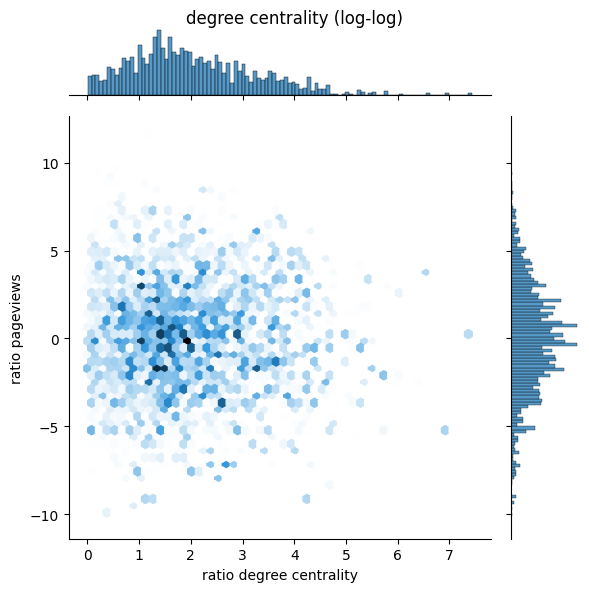

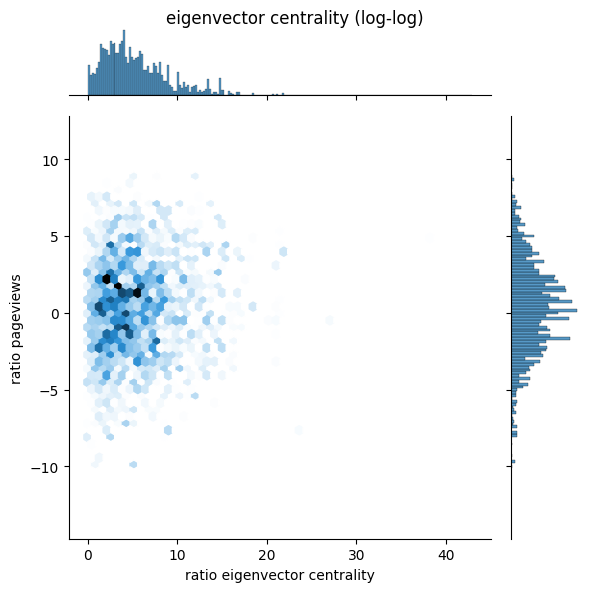

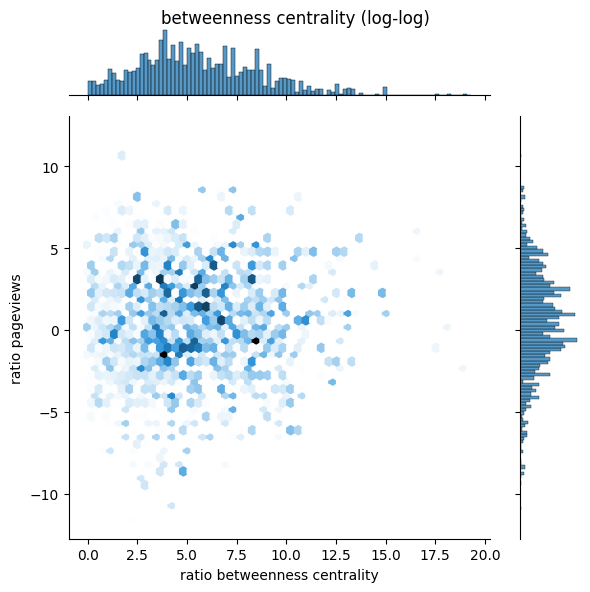

In [61]:
#| echo: false
#| warnings: false
r_squared = {}
for ab, t in zip([ab_test_degree, ab_test_eigenvector, ab_test_betweenness], ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    
    data= pd.DataFrame({
        "log_pageviews1": np.log2(ab.pageviews1),
        "log_pageviews2": np.log2(ab.pageviews2),
        "log_centrality1": np.log2(ab[t + "1"]),
        "log_centrality2": np.log2(ab[t + "2"])
    }).replace([np.inf, -np.inf], np.nan).dropna()
    
    g = sns.jointplot(x=data["log_centrality1"] - data["log_centrality2"],
                  y=data["log_pageviews1"] - data["log_pageviews2"], kind="hex")
    g.set_axis_labels("ratio " + t.replace("_", " "), "ratio pageviews")
    
    g.fig.suptitle(t.replace("_", " ") + " (log-log)")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.set_axis_labels("ratio " + t.replace("_", " "), "ratio pageviews")

    model = smf.ols(formula="logratio_pageviews ~ logratio_centrality", 
                    data={
                        "logratio_pageviews": data["log_pageviews1"] - data["log_pageviews2"],
                        "logratio_centrality": data["log_centrality1"] - data["log_centrality2"]
                    })

    np.random.seed(83)
    res = model.fit()

    increase = math.pow(2,res.params["logratio_centrality"]) * 100 -100
    r_squared[t] = float(res.summary().tables[0].data[0][3].strip())

    print("For %s.\n\tWe find an average increase of %.2f%% in pageviews per 2x increase in centrality" % (t.replace("_", " "), increase))
    print(res.summary().tables[1])
    print()

In the end we find very little increases in pageviews when varying the centrality of actors. There is even a slight decrease concerning the degree centrality, although it is not statistically significant. The largest increase is with the eigenvalue centrality, with an average increase of 4.73% in pageviews per 2x increase in centrality, but with an R^2 value of 0.007. We conclude that if there is a relationship between the centrality of actors and their popularity, it is barely noticeable and not interesting.